In [1]:
import os
from pathlib import Path

import cv2
import mahotas as mh
import matplotlib.pyplot as plt
import numpy as np
from loguru import logger
from skimage import filters, measure, morphology, segmentation, color
from scipy import ndimage as ndi

import cellseg.src.convert_worker as cw
import cellseg.src.image_worker as iw

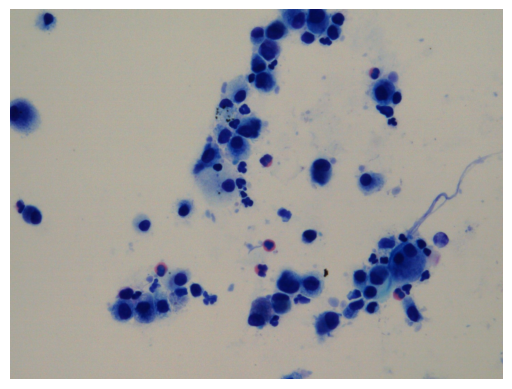

In [2]:
img = mh.imread("Images/image/P00002.jpg")
plt.axis("off")

plt.imshow(img)

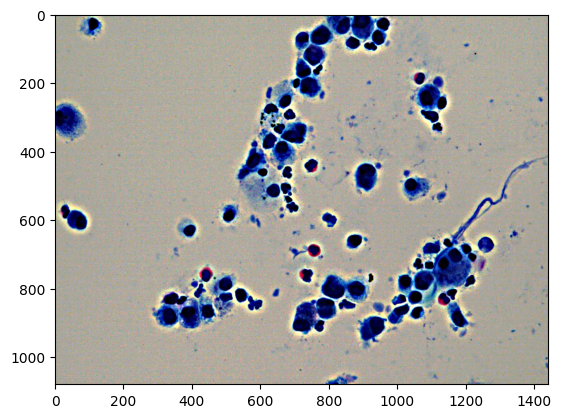

In [3]:
img_unsharp = iw.unsharp_mask_img(img)

plt.imshow(img_unsharp)

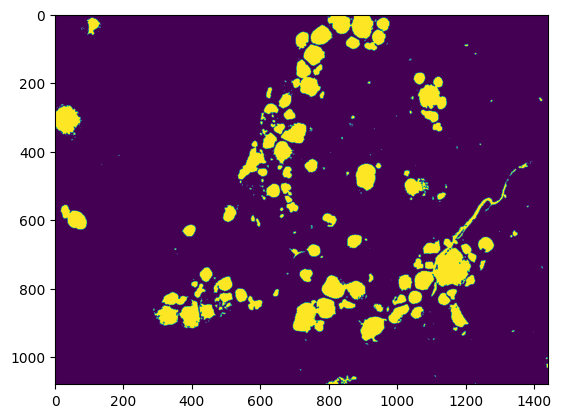

In [4]:
r, g, b = cw.separate_layers(img_unsharp)
bin_otsu = cw.convert_grayscale_to_bin_otsu(g)

plt.imshow(bin_otsu)

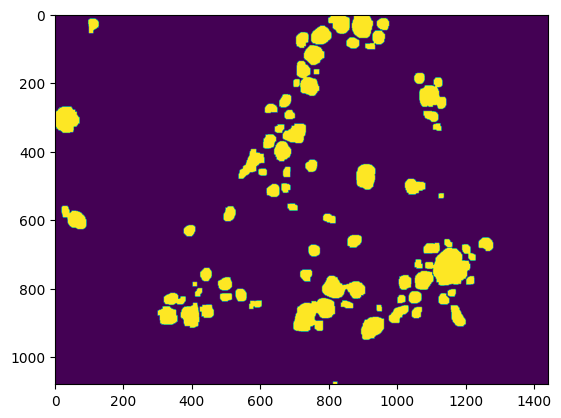

In [5]:
g_bin_otsu_morp = iw.close_holes_remove_noise(bin_otsu, iterations=6)

plt.imshow(g_bin_otsu_morp)

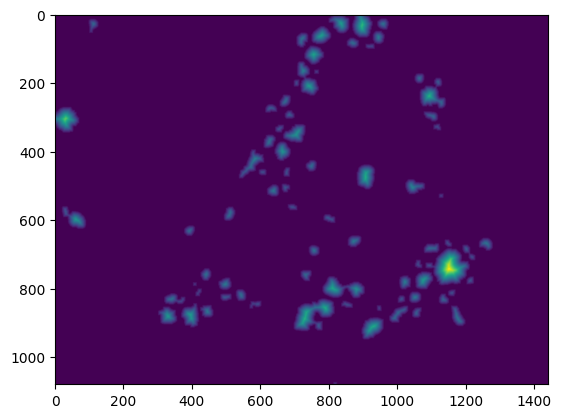

In [6]:
distance = cv2.distanceTransform(g_bin_otsu_morp.astype(np.uint8), cv2.DIST_L2, 5)

plt.imshow(distance)

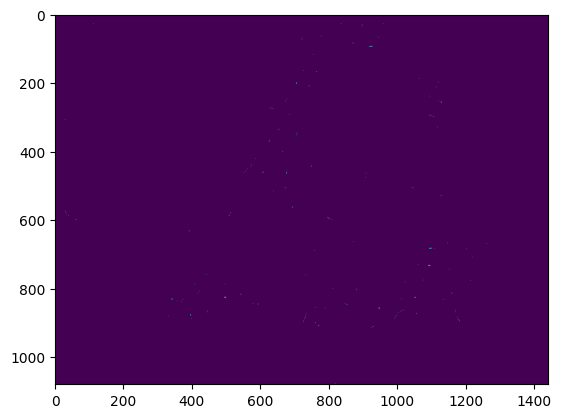

In [7]:
local_maxi = morphology.local_maxima(distance)
markers = measure.label(local_maxi)

plt.imshow(local_maxi)

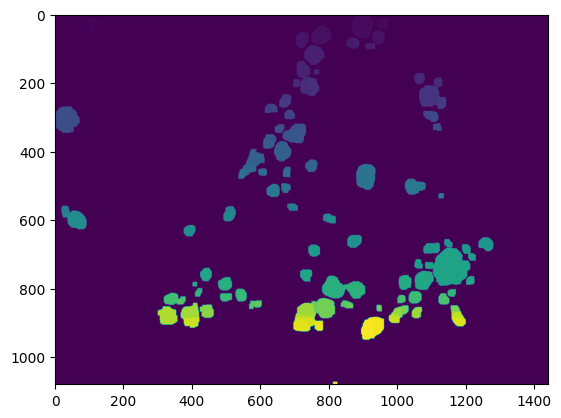

In [8]:
labels = segmentation.watershed(-distance, markers, mask=g_bin_otsu_morp)

plt.imshow(labels)

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


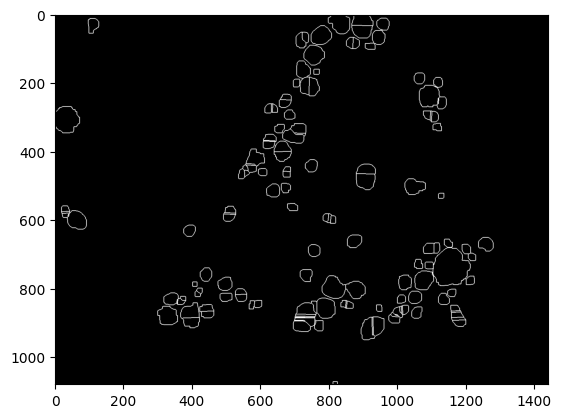

In [9]:
boundaries = segmentation.find_boundaries(labels)


plt.imshow(boundaries, cmap="gray")
print(boundaries)

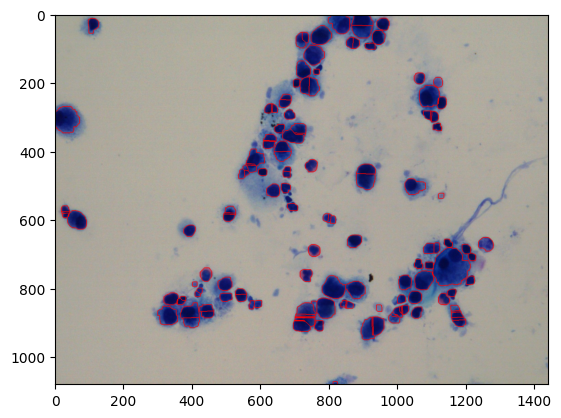

In [10]:
boundaries_mask = np.zeros_like(img[:, :, 0], dtype=bool)
boundaries_mask[boundaries] = True

boundaries_overlay = img.copy()

boundaries_overlay[boundaries_mask] = [255, 0, 0]

plt.imshow(boundaries_overlay)

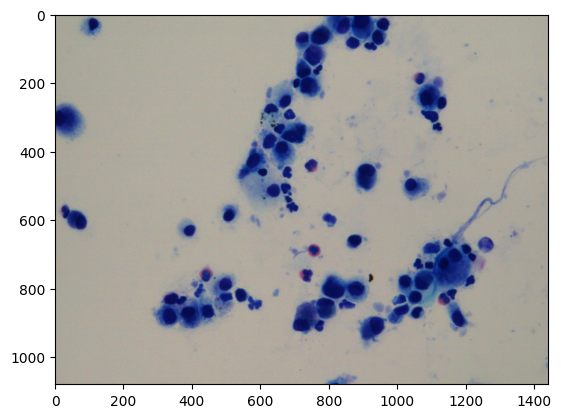

In [11]:
plt.imshow(img)

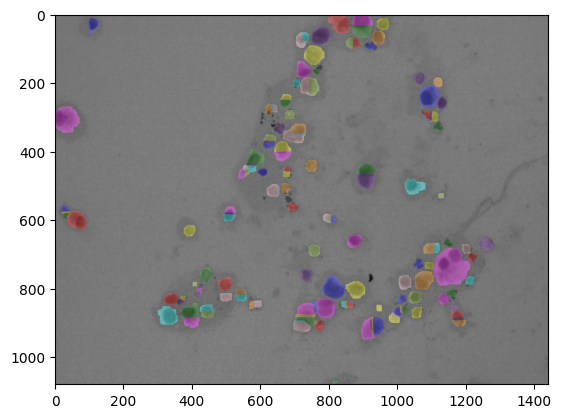

In [12]:
image_label_overlay = color.label2rgb(labels, image=img, bg_label=0)

plt.imshow(image_label_overlay)

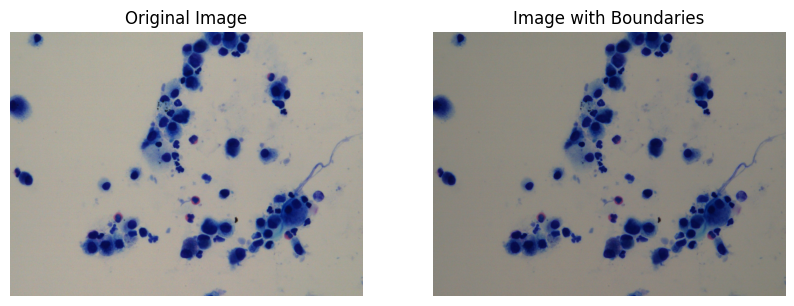

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Read the original image
original_image = cv2.imread("Images/image/P00002.jpg")

# Step 2: Convert the image to grayscale (for edge detection)
gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

# Step 3: Apply edge detection (Canny in this case)
edges = cv2.Canny(gray_image, 100, 200)

# Step 4: Create a colored overlay for edges (e.g., in red)
edges_colored = np.zeros_like(original_image)  # Create an empty image like the original
edges_colored[edges != 0] = [255, 0, 0]  # Set the edge pixels to red ([B, G, R])

# Step 5: Blend the original image with the red boundaries
blended_image = cv2.addWeighted(original_image, 0.8, edges_colored, 0.2, 0)

# Step 6: Display the results
plt.figure(figsize=(10, 5))

# Show original image
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
plt.axis("off")

# Show image with boundaries
plt.subplot(1, 2, 2)
plt.title("Image with Boundaries")
plt.imshow(cv2.cvtColor(blended_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
plt.axis("off")

plt.show()

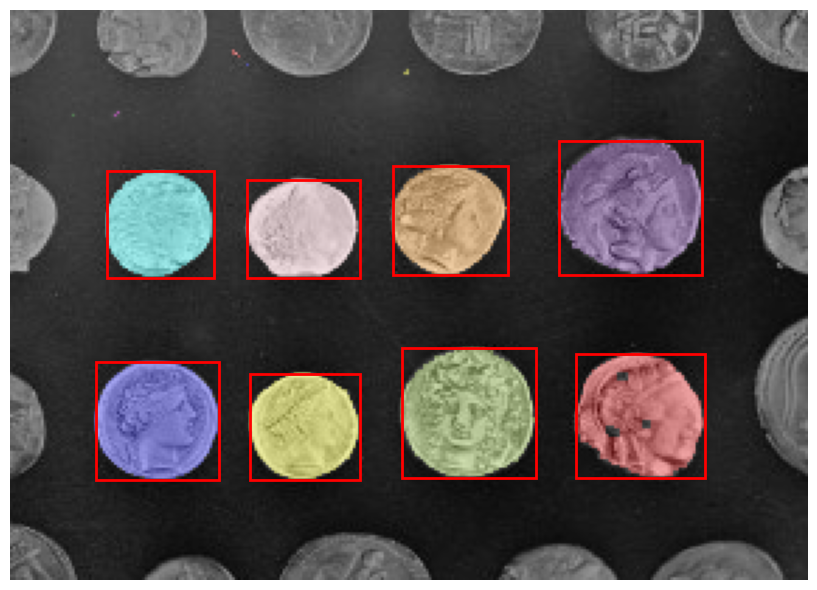

In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb


image = data.coins()[50:-50, 50:-50]

# apply threshold
thresh = threshold_otsu(image)
bw = closing(image > thresh, square(3))

# remove artifacts connected to image border
cleared = clear_border(bw)
# label image regions
label_image = label(cleared)
# plt.imshow(label_image)
# to make the background transparent, pass the value of `bg_label`,
# and leave `bg_color` as `None` and `kind` as `overlay`
image_label_overlay = label2rgb(label_image, image=image, bg_label=0)
# plt.imshow(image_label_overlay)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 100:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle(
            (minc, minr),
            maxc - minc,
            maxr - minr,
            fill=False,
            edgecolor="red",
            linewidth=2,
        )
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()